# OOTD Param selection @aws



Param 바꿔 가면서 test set accuracy로 param setting 하던 파일임.

SJP


In [16]:
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

caffe.set_device(0)
caffe.set_mode_gpu()


#caffe.set_mode_cpu()

import numpy as np
from pylab import *
%matplotlib inline
import tempfile

# Helper function for deprocessing preprocessed images, e.g., for display.
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

In [17]:
# Download just a small subset of the data for this exercise.
# (2000 of 80K images, 5 of 20 labels.)
# To download the entire dataset, set `full_dataset = True`.
full_dataset = False
if full_dataset:
    NUM_OOTD_IMAGES = NUM_OOTD_LABELS = -1
else:
    NUM_OOTD_IMAGES = 4900
    NUM_OOTD_LABELS = 3

# This downloads the ilsvrc auxiliary data (mean file, etc),
# and a subset of 2000 images for the style recognition task.
import os
#os.chdir(caffe_root)  # run scripts from caffe root
#!data/ilsvrc12/get_ilsvrc_aux.sh
#!scripts/download_model_binary.py models/bvlc_reference_caffenet
#!python examples/finetune_flickr_style/assemble_data_ootd.py \
#    --workers=-1  --seed=1701 \
#    --images=$NUM_OOTD_IMAGES  --label=$NUM_STYLE_LABELS
    
print NUM_OOTD_IMAGES, NUM_OOTD_LABELS

# back to examples
#os.chdir('examples')

4900 3


# Weights loaded from locally trained adam_exp2

#Testing different params exp2 : 
#weight_decay = 3e-3 (increased from 5e-4)
#type = 'Adam'
#s.momentum = 0.9, s.momentum2 = 0.999, s.delta = 1e-7
#s.lr_policy = 'step', s.gamma = 0.9, s.stepsize = 100
#niter = 1000


In [18]:
import os
weights = caffe_root + 'models/ootd/weights.pretrained_adam_exp2.caffemodel'
assert os.path.exists(weights)

In [19]:
# Load style labels to style_labels
ootd_label_file = caffe_root + 'data/ootd/ootd_names.txt'
ootd_labels = list(np.loadtxt(ootd_label_file, str, delimiter='\n'))
if NUM_OOTD_LABELS > 0:
    ootd_labels = ootd_labels[:NUM_OOTD_LABELS]
print '\nLoaded ootd labels:\n', ', '.join(ootd_labels)


Loaded ootd labels:
Delete, Keep, Feature


# aws exp5

In [20]:
train_net_path = caffe_root + 'models/ootd/ootd_train.prototxt'
test_net_path = caffe_root + 'models/ootd/ootd_test.prototxt'
solver_config_path = caffe_root + 'models/ootd/ootd_solver.prototxt'




# weight_decay = 4e-3
# type = 'Adam'
# s.momentum = 0.9, s.momentum2 = 0.999, s.delta = 1e-7
# s.lr_policy = 'step', s.gamma = 0.9, s.stepsize = 100
    


from caffe.proto import caffe_pb2


def solver(train_net_path, test_net_path=test_net_path, base_lr=0.00001, weight_decay = 2.6e-3):
    s = caffe_pb2.SolverParameter()

    
    # Set a seed for reproducible experiments:
    # this controls for randomization in training.
    s.random_seed = 0xCAFFE

    
    
    
    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 1000  # Test after every 1000 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.

    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    s.iter_size = 1
    
    s.max_iter = 100000     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'Adam'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.95
    s.stepsize = 100
    
    
    # Set `lr_policy` to define how the learning rate changes during training.
    # This is the same policy as our default LeNet.
    #s.lr_policy = 'inv'
    #s.gamma = 0.0001
    #s.power = 0.75
    # EDIT HERE to try the fixed rate (and compare with adaptive solvers)
    # `fixed` is the simplest policy that keeps the learning rate constant.
    # s.lr_policy = 'fixed'


    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.momentum2 = 0.999
    s.delta = 1e-7
    s.weight_decay = weight_decay

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 10000
    s.snapshot_prefix = caffe_root + 'models/ootd/ootd'
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    # Write the solver to a temporary file and return its filename.
    #with tempfile.NamedTemporaryFile(delete=False) as f:
    #    f.write(str(s))
    #    return f.name
    
    with open(solver_config_path, 'w') as f:
        f.write(str(s))
        return f.name
    


In [21]:
def run_solvers(niter, solvers, disp_interval=10):
    """Run solvers for niter iterations,
       returning the loss and accuracy recorded each iteration.
       `solvers` is a list of (name, solver) tuples."""
    blobs = ('loss', 'acc')
    loss, acc = ({name: np.zeros(niter) for name, _ in solvers}
                 for _ in blobs)
    for it in range(niter):
        for name, s in solvers:
            s.step(1)  # run a single SGD step in Caffe
            loss[name][it], acc[name][it] = (s.net.blobs[b].data.copy()
                                             for b in blobs)
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%2d%%' %
                                  (n, loss[n][it], np.round(100*acc[n][it]))
                                  for n, _ in solvers)
            print '%3d) %s' % (it, loss_disp)     
    # Save the learned weights from both nets.
    #weight_dir = tempfile.mkdtemp()
    #weights = {}
    weight_dir = caffe_root + 'models/ootd/'
    weights = {}
    
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        weights[name] = os.path.join(weight_dir, filename)
        s.net.save(weights[name])
    return loss, acc, weights

In [22]:

niter = 1000 
ootd_solver_filename = solver(train_net_path)
ootd_solver = caffe.get_solver(ootd_solver_filename)
ootd_solver.net.copy_from(weights)

print 'Running solvers for %d iterations...' % niter
solvers = [('ubuntu_adam_exp5', ootd_solver)]

exp_loss, exp_acc, exp_weights = run_solvers(niter, solvers)
print 'Done.'

ubuntu_weights_exp = exp_weights['ubuntu_adam_exp5']

train_loss = exp_loss['ubuntu_adam_exp5']
train_acc = exp_acc['ubuntu_adam_exp5']

# Delete solvers to save memory.
del ootd_solver, solvers

Running solvers for 1000 iterations...
  0) ubuntu_adam_exp5: loss=0.135, acc=95%
 10) ubuntu_adam_exp5: loss=0.084, acc=97%
 20) ubuntu_adam_exp5: loss=0.200, acc=92%
 30) ubuntu_adam_exp5: loss=0.078, acc=98%
 40) ubuntu_adam_exp5: loss=0.206, acc=91%
 50) ubuntu_adam_exp5: loss=0.180, acc=95%
 60) ubuntu_adam_exp5: loss=0.216, acc=92%
 70) ubuntu_adam_exp5: loss=0.118, acc=95%
 80) ubuntu_adam_exp5: loss=0.210, acc=94%
 90) ubuntu_adam_exp5: loss=0.176, acc=94%
100) ubuntu_adam_exp5: loss=0.222, acc=92%
110) ubuntu_adam_exp5: loss=0.076, acc=98%
120) ubuntu_adam_exp5: loss=0.104, acc=97%
130) ubuntu_adam_exp5: loss=0.146, acc=95%
140) ubuntu_adam_exp5: loss=0.160, acc=95%
150) ubuntu_adam_exp5: loss=0.083, acc=98%
160) ubuntu_adam_exp5: loss=0.131, acc=94%
170) ubuntu_adam_exp5: loss=0.177, acc=95%
180) ubuntu_adam_exp5: loss=0.094, acc=95%
190) ubuntu_adam_exp5: loss=0.138, acc=92%
200) ubuntu_adam_exp5: loss=0.143, acc=94%
210) ubuntu_adam_exp5: loss=0.187, acc=95%
220) ubuntu_ada

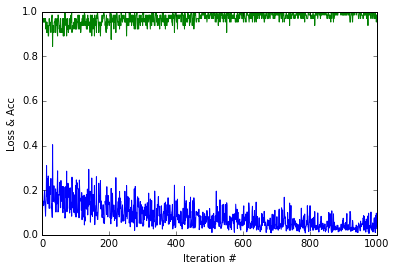

In [23]:
plot(np.vstack([train_loss, train_acc]).T)
xlabel('Iteration #')
ylabel('Loss & Acc')

In [24]:
def eval_ootd_net(weights, test_iters=50):
    test_net = caffe.Net(test_net_path, weights, caffe.TEST)
    accuracy = 0
    correct_delete = 0.
    all_delete = 0.
    for it in xrange(test_iters):
        accuracy += test_net.forward()['acc']
        correct_delete += sum(logical_and((test_net.blobs['probs'].data.argmax(1) == 0), 
                                   (test_net.blobs['label'].data == 0)))
        all_delete += sum(test_net.blobs['label'].data == 0)

    accuracy /= test_iters
    delete_accuracy = correct_delete / all_delete
    return test_net, accuracy, delete_accuracy

In [25]:
test_net, accuracy, delete_accuracy = eval_ootd_net(ubuntu_weights_exp)
print 'Accuracy, exp@aws: %3.1f%%' % (100*accuracy, )
print 'Delete Accuracy, exp@aws: %3.1f%%' % (100*delete_accuracy, )


Accuracy, exp@aws: 79.4%
Delete Accuracy, exp@aws: 67.3%


In [26]:


def disp_preds(net, image, labels=ootd_labels, k=3, name='ootd'):
    input_blob = net.blobs['data']
    net.blobs['data'].data[0, ...] = image
    probs = net.forward(start='conv1')['probs'][0]
    top_k = (-probs).argsort()[:k]
    print 'top %d predicted %s labels =' % (k, name)
    print '\n'.join('\t(%d) %5.2f%% %s' % (i+1, 100*probs[p], labels[p])
                    for i, p in enumerate(top_k))



actual label = Delete
top 3 predicted ootd labels =
	(1) 100.00% Delete
	(2)  0.00% Keep
	(3)  0.00% Feature


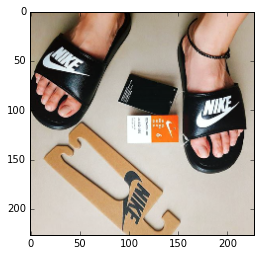

In [27]:
batch_index = 2
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 81.28% Delete
	(2) 13.32% Keep
	(3)  5.40% Feature


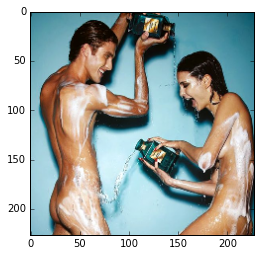

In [28]:
batch_index = 3
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 93.48% Keep
	(2)  6.41% Delete
	(3)  0.11% Feature


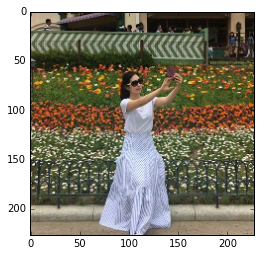

In [29]:
batch_index = 4
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 99.99% Delete
	(2)  0.00% Keep
	(3)  0.00% Feature


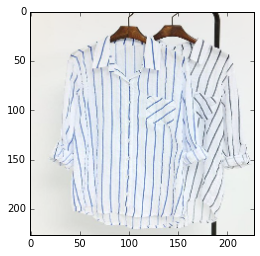

In [30]:
batch_index = 5
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 100.00% Delete
	(2)  0.00% Keep
	(3)  0.00% Feature


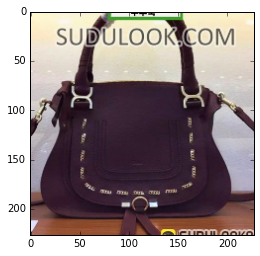

In [31]:
batch_index = 6
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_preds(test_net, image)

actual label = Delete
top 3 predicted ootd labels =
	(1) 97.61% Delete
	(2)  1.51% Keep
	(3)  0.88% Feature


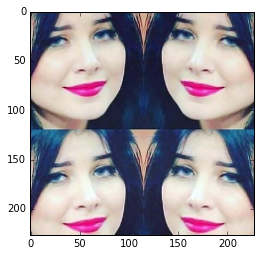

In [32]:
batch_index = 7
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 99.77% Keep
	(2)  0.13% Delete
	(3)  0.10% Feature


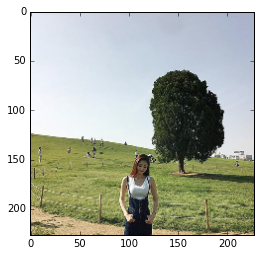

In [33]:
batch_index = 8
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 99.94% Keep
	(2)  0.06% Feature
	(3)  0.00% Delete


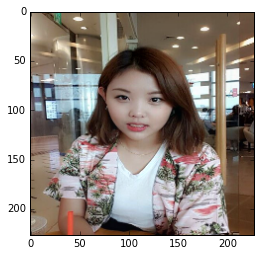

In [34]:
batch_index = 9
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 99.37% Keep
	(2)  0.43% Delete
	(3)  0.21% Feature


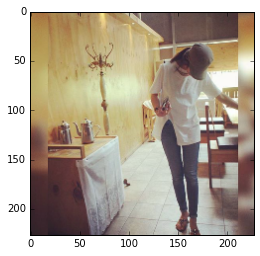

In [35]:
batch_index = 10
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_preds(test_net, image)

actual label = Keep
top 3 predicted ootd labels =
	(1) 99.45% Keep
	(2)  0.40% Feature
	(3)  0.16% Delete
(3, 227, 227)


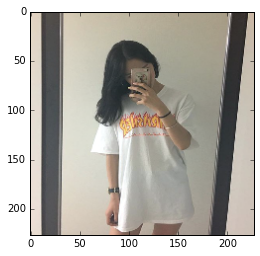

In [44]:
batch_index = 11
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', ootd_labels[int(test_net.blobs['label'].data[batch_index])]
disp_preds(test_net, image)
print image.shape

In [46]:
# download an image
my_image_url = "https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/13437264_283986521955286_659366456_n.jpg?ig_cache_key=MTI3NjY1MDQ2NzI1NzA2NjEyMQ%3D%3D.2"  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url


--2016-06-20 10:39:43--  https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/13437264_283986521955286_659366456_n.jpg?ig_cache_key=MTI3NjY1MDQ2NzI1NzA2NjEyMQ%3D%3D.2
Resolving scontent.cdninstagram.com (scontent.cdninstagram.com)... 31.13.70.52, 2a03:2880:f00d:14:face:b00c:0:43fe
접속 scontent.cdninstagram.com (scontent.cdninstagram.com)|31.13.70.52|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 76376 (75K) [image/jpeg]
Saving to: ‘image.jpg’

100%[======================================>] 76,376      --.-K/s   in 0.05s   

2016-06-20 10:39:43 (1.52 MB/s) - ‘image.jpg’ saved [76376/76376]



In [47]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


(3, 227, 227)
top 3 predicted ootd labels =
	(1) 71.69% Delete
	(2) 26.69% Keep
	(3)  1.61% Feature


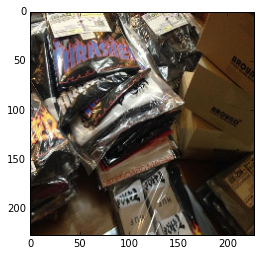

In [48]:
image = caffe.io.load_image('image.jpg')
img = transformer.preprocess('data', image)

print img.shape

plt.imshow(deprocess_net_image(img))

disp_preds(test_net, img)


In [37]:

test_net_path = caffe_root + 'models/ootd/ootd_test.prototxt'


import os
weights = caffe_root + 'models/ootd/weights.ubuntu_adam_exp5.caffemodel'
assert os.path.exists(weights)

net = caffe.Net(test_net_path, weights, caffe.TEST)


In [49]:


# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


In [50]:
# download an image
my_image_url = "https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/13437264_283986521955286_659366456_n.jpg?ig_cache_key=MTI3NjY1MDQ2NzI1NzA2NjEyMQ%3D%3D.2"  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url


--2016-06-20 10:42:38--  https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/13437264_283986521955286_659366456_n.jpg?ig_cache_key=MTI3NjY1MDQ2NzI1NzA2NjEyMQ%3D%3D.2
Resolving scontent.cdninstagram.com (scontent.cdninstagram.com)... 31.13.70.52, 2a03:2880:f022:14:face:b00c:0:43fe
접속 scontent.cdninstagram.com (scontent.cdninstagram.com)|31.13.70.52|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 76376 (75K) [image/jpeg]
Saving to: ‘image.jpg’

100%[======================================>] 76,376      --.-K/s   in 0.05s   

2016-06-20 10:42:38 (1.53 MB/s) - ‘image.jpg’ saved [76376/76376]



(3, 227, 227)
top 3 predicted ootd labels =
	(1) 71.69% Delete
	(2) 26.69% Keep
	(3)  1.61% Feature


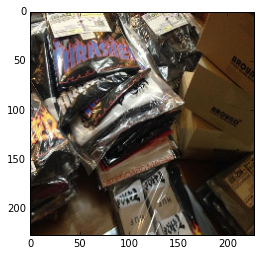

In [51]:
image = caffe.io.load_image('image.jpg')
img = transformer.preprocess('data', image)

print img.shape

plt.imshow(deprocess_net_image(img))

disp_preds(net, img)

In [39]:
# download an image
my_image_url = "https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/13437264_283986521955286_659366456_n.jpg?ig_cache_key=MTI3NjY1MDQ2NzI1NzA2NjEyMQ%3D%3D.2"  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[0, ...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['probs'].data[0]

# sort three predictions from softmax output
top_inds = output_prob.argsort()[::-1][:3]

print top_inds



--2016-06-20 10:30:23--  https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/13437264_283986521955286_659366456_n.jpg?ig_cache_key=MTI3NjY1MDQ2NzI1NzA2NjEyMQ%3D%3D.2
Resolving scontent.cdninstagram.com (scontent.cdninstagram.com)... 31.13.70.52, 2a03:2880:f00d:14:face:b00c:0:43fe
접속 scontent.cdninstagram.com (scontent.cdninstagram.com)|31.13.70.52|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 76376 (75K) [image/jpeg]
Saving to: ‘image.jpg’

100%[======================================>] 76,376      --.-K/s   in 0.05s   

2016-06-20 10:30:23 (1.52 MB/s) - ‘image.jpg’ saved [76376/76376]

[1 0 2]


In [40]:
# load ootd labels
# Load style labels to style_labels
ootd_label_file = caffe_root + 'data/ootd/ootd_names.txt'
ootd_labels = list(np.loadtxt(ootd_label_file, str, delimiter='\n'))

print 'predicted probabilities for three labels ='
print '\n'.join('\t(%d) %5.2f%% %s' % (i+1, 100*output_prob[p], ootd_labels[p])
                for i, p in enumerate(top_inds))



predicted probabilities for three labels =
	(1) 99.27% Keep
	(2)  0.73% Delete
	(3)  0.00% Feature
